# Mining Function Specifications

When testing a program, one not only needs to cover its several behaviors; one also needs to _check_ whether the result is as expected.  In this chapter, we introduce a technique that allows us to _mine_ function specifications from a set of given executions, resulting in abstract and formal _descriptions_ of what the function expects and what it delivers.  

These so-called _dynamic invariants_ produce pre- and post-conditions over function arguments and variables from a set of executions.  They are useful in a variety of contexts:

* Dynamic invariants provide important information for [symbolic fuzzing](SymbolicFuzzer.ipynb), such as types and ranges of function arguments.
* Dynamic invariants provide pre- and postconditions for formal program proofs and verification.
* Dynamic invariants provide a large number of assertions that can check whether function behavior has changed
* Checks provided by dynamic invariants can be very useful as _oracles_ for checking the effects of generated tests

Traditionally, dynamic invariants are dependent on the executions they are derived from.  However, when paired with comprehensive test generators, they quickly become very precise, as we show in this chapter.

**Prerequisites**

* You should be familiar with tracing program executions, as in the [chapter on coverage](Coverage.ipynb).
* Later in this section, we access the internal _abstract syntax tree_ representations of Python programs and transform them, as in the [chapter on information flow](InformationFlow.ipynb).

In [1]:
import bookutils

In [2]:
import Coverage
import Intro_Testing

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.DynamicInvariants import <identifier>
```

and then make use of the following features.


This chapter provides two classes that automatically extract specifications from a function and a set of inputs:

* `TypeAnnotator` for _types_, and
* `InvariantAnnotator` for _pre-_ and _postconditions_.

Both work by _observing_ a function and its invocations within a `with` clause.  Here is an example for the type annotator:

```python
>>> def sum(a, b):
>>>     return a + b
>>> with TypeAnnotator() as type_annotator:
>>>     sum(1, 2)
>>>     sum(-4, -5)
>>>     sum(0, 0)
```
The `typed_functions()` method will return a representation of `sum2()` annotated with types observed during execution.

```python
>>> print(type_annotator.typed_functions())
def sum(a: int, b: int) -> int:
    return a + b

```
The invariant annotator works in a similar fashion:

```python
>>> with InvariantAnnotator() as inv_annotator:
>>>     sum(1, 2)
>>>     sum(-4, -5)
>>>     sum(0, 0)
```
The `functions_with_invariants()` method will return a representation of `sum2()` annotated with inferred pre- and postconditions that all hold for the observed values.

```python
>>> print(inv_annotator.functions_with_invariants())
@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: a == return_value - b)
@postcondition(lambda return_value, b, a: b == return_value - a)
@postcondition(lambda return_value, b, a: isinstance(return_value, int))
@postcondition(lambda return_value, b, a: return_value == a + b)
@postcondition(lambda return_value, b, a: return_value == b + a)
def sum(a, b):
    return a + b


```
Such type specifications and invariants can be helpful as _oracles_ (to detect deviations from a given set of runs) as well as for all kinds of _symbolic code analyses_.  The chapter gives details on how to customize the properties checked for.



## Specifications and Assertions

When implementing a function or program, one usually works against a _specification_ – a set of documented requirements to be satisfied by the code.  Such specifications can come in natural language.  A formal specification, however, allows the computer to check whether the specification is satisfied.

In the [introduction to testing](Intro_Testing.ipynb), we have seen how _preconditions_ and _postconditions_ can describe what a function does.  Consider the following (simple) square root function:

In [3]:
def any_sqrt(x):
    assert x >= 0  # Precondition
    
    ...
    
    assert result * result == x  # Postcondition
    return result

The assertion `assert p` checks the condition `p`; if it does not hold, execution is aborted.  Here, the actual body is not yet written; we use the assertions as a specification of what `any_sqrt()` _expects_, and what it _delivers_.

The topmost assertion is the _precondition_, stating the requirements on the function arguments.  The assertion at the end is the _postcondition_, stating the properties of the function result (including its relationship with the original arguments).  Using these pre- and postconditions as a specification, we can now go and implement a square root function that satisfies them.  Once implemented, we can have the assertions check at runtime whether `any_sqrt()` works as expected; a [symbolic](SymbolicFuzzer.ipynb) or [concolic](ConcolicFuzzer.ipynb) test generator will even specifically try to find inputs where the assertions do _not_ hold.  (An assertion can be seen as a conditional branch towards aborting the execution, and any technique that tries to cover all code branches will also try to invalidate as many assertions as possible.)

However, not every piece of code is developed with explicit specifications in the first place; let alone does most code comes with formal pre- and post-conditions.  (Just take a look at the chapters in this book.)  This is a pity: As Ken Thompson famously said, "Without specifications, there are no bugs – only surprises".  It is also a problem for testing, since, of course, testing needs some specification to test against.  This raises the interesting question: Can we somehow _retrofit_ existing code with "specifications" that properly describe their behavior, allowing developers to simply _check_ them rather than having to write them from scratch?  This is what we do in this chapter.

## Why Generic Error Checking is Not Enough

Before we go into _mining_ specifications, let us first discuss why it could be useful to _have_ them.  As a motivating example, consider the full implementation of a square root function from the [introduction to testing](Intro_Testing.ipynb):

In [4]:
import bookutils

In [5]:
def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

`my_sqrt()` does not come with any functionality that would check types or values.  Hence, it is easy for callers to make mistakes when calling `my_sqrt()`:

In [6]:
from ExpectError import ExpectError, ExpectTimeout

In [7]:
with ExpectError():
    my_sqrt("foo")

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/829521914.py", line 2, in <cell line: 1>
    my_sqrt("foo")
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2661069967.py", line 4, in my_sqrt
    guess = x / 2
TypeError: unsupported operand type(s) for /: 'str' and 'int' (expected)


In [8]:
with ExpectError():
    x = my_sqrt(0.0)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/1975547953.py", line 2, in <cell line: 1>
    x = my_sqrt(0.0)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2661069967.py", line 7, in my_sqrt
    guess = (approx + x / approx) / 2
ZeroDivisionError: float division by zero (expected)


At least, the Python system catches these errors at runtime.  The following call, however, simply lets the function enter an infinite loop:

In [9]:
with ExpectTimeout(1):
    x = my_sqrt(-1.0)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/1349814288.py", line 2, in <cell line: 1>
    x = my_sqrt(-1.0)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2661069967.py", line 7, in my_sqrt
    guess = (approx + x / approx) / 2
  File "/Users/zeller/Projects/fuzzingbook/notebooks/Timeout.ipynb", line 43, in timeout_handler
    raise TimeoutError()
TimeoutError (expected)


Our goal is to avoid such errors by _annotating_ functions with information that prevents errors like the above ones.  The idea is to provide a _specification_ of expected properties – a specification that can then be checked at runtime or statically.

\todo{Introduce the concept of *contract*.}

## Specifying and Checking Data Types

For our Python code, one of the most important "specifications" we need is *types*.  Python being a "dynamically" typed language means that all data types are determined at run time; the code itself does not explicitly state whether a variable is an integer, a string, an array, a dictionary – or whatever.

As _writer_ of Python code, omitting explicit type declarations may save time (and allows for some fun hacks).  It is not sure whether a lack of types helps in _reading_ and _understanding_ code for humans.  For a _computer_ trying to analyze code, the lack of explicit types is detrimental.  If, say, a constraint solver, sees `if x:` and cannot know whether `x` is supposed to be a number or a string, this introduces an _ambiguity_.   Such ambiguities may multiply over the entire analysis in a combinatorial explosion – or in the analysis yielding an overly inaccurate result.

Python 3.6 and later allows data types as _annotations_ to function arguments (actually, to all variables) and return values.  We can, for instance, state that `my_sqrt()` is a function that accepts a floating-point value and returns one:

In [10]:
def my_sqrt_with_type_annotations(x: float) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    return my_sqrt(x)

By default, such annotations are ignored by the Python interpreter.  Therefore, one can still call `my_sqrt_typed()` with a string as an argument and get the exact same result as above.  However, one can make use of special _typechecking_ modules that would check types – _dynamically_ at runtime or _statically_ by analyzing the code without having to execute it.

### Excursion: Runtime Type Checking

(Commented out as `enforce` is not supported by Python 3.9)

The Python `enforce` package provides a function decorator that automatically inserts type-checking code that is executed at runtime.  Here is how to use it:

In [11]:
# import enforce

In [12]:
# @enforce.runtime_validation
# def my_sqrt_with_checked_type_annotations(x: float) -> float:
#     """Computes the square root of x, using the Newton-Raphson method"""
#     return my_sqrt(x)

Now, invoking `my_sqrt_with_checked_type_annotations()` raises an exception when invoked with a type dfferent from the one declared:

In [13]:
# with ExpectError():
#     my_sqrt_with_checked_type_annotations(True)

Note that this error is not caught by the "untyped" variant, where passing a boolean value happily returns $\sqrt{1}$ as result. 

In [14]:
# my_sqrt(True)

In Python (and other languages), the boolean values `True` and `False` can be implicitly converted to the integers 1 and 0; however, it is hard to think of a call to `sqrt()` where this would not be an error.

### End of Excursion

### Static Type Checking

Type annotations can also be checked _statically_ – that is, without even running the code.  Let us create a simple Python file consisting of the above `my_sqrt_typed()` definition and a bad invocation.

In [15]:
import inspect
import tempfile

In [16]:
f = tempfile.NamedTemporaryFile(mode='w', suffix='.py')
f.name

'/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp3u10w_q_.py'

In [17]:
f.write(inspect.getsource(my_sqrt))
f.write('\n')
f.write(inspect.getsource(my_sqrt_with_type_annotations))
f.write('\n')
f.write("print(my_sqrt_with_type_annotations('123'))\n")
f.flush()

These are the contents of our newly created Python file:

In [18]:
from bookutils import print_file

In [19]:
print_file(f.name)

def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

def my_sqrt_with_type_annotations(x: float) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    return my_sqrt(x)

print(my_sqrt_with_type_annotations('123'))

[Mypy](http://mypy-lang.org) is a type checker for Python programs.  As it checks types statically, types induce no overhead at runtime; plus, a static check can be faster than a lengthy series of tests with runtime type checking enabled.  Let us see what `mypy` produces on the above file:

In [20]:
import subprocess

In [21]:
result = subprocess.run(["mypy", "--strict", f.name], universal_newlines=True, stdout=subprocess.PIPE)
del f  # Delete temporary file

In [22]:
print(result.stdout)

/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp3u10w_q_.py:1: error: Function is missing a type annotation
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp3u10w_q_.py:12: error: Returning Any from function declared to return "float"
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp3u10w_q_.py:12: error: Call to untyped function "my_sqrt" in typed context
/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/tmp3u10w_q_.py:14: error: Argument 1 to "my_sqrt_with_type_annotations" has incompatible type "str"; expected "float"
Found 4 errors in 1 file (checked 1 source file)



We see that `mypy` complains about untyped function definitions such as `my_sqrt()`; most important, however, it finds that the  call to `my_sqrt_with_type_annotations()` in the last line has the wrong type.

With `mypy`, we can achieve the same type safety with Python as in statically typed languages – provided that we as programmers also produce the necessary type annotations.  Is there a simple way to obtain these?

## Mining Type Specifications

Our first task will be to mine type annotations (as part of the code) from _values_ we observe at run time.  These type annotations would be _mined_ from actual function executions, _learning_ from (normal) runs what the expected argument and return types should be.  By observing a series of calls such as these, we could infer that both `x` and the return value are of type `float`:

In [23]:
y = my_sqrt(25.0)
y

5.0

In [24]:
y = my_sqrt(2.0)
y

1.414213562373095

How can we mine types from executions?  The answer is simple: 

1. We _observe_ a function during execution
2. We track the _types_ of its arguments
3. We include these types as _annotations_ into the code.

To do so, we can make use of Python's tracing facility we already observed in the [chapter on coverage](Coverage.ipynb).  With every call to a function, we retrieve the arguments, their values, and their types.

### Tracking Calls

To observe argument types at runtime, we define a _tracer function_ that tracks the execution of `my_sqrt()`, checking its arguments and return values.  The `Tracker` class is set to trace functions in a `with` block as follows:

```python
with Tracker() as tracker:
    function_to_be_tracked(...)
info = tracker.collected_information()
```

As in the [chapter on coverage](Coverage.ipynb), we use the `sys.settrace()` function to trace individual functions during execution.  We turn on tracking when the `with` block starts; at this point, the `__enter__()` method is called.  When execution of the `with` block ends, `__exit()__` is called.  

In [25]:
import sys

In [26]:
class Tracker:
    def __init__(self, log=False):
        self._log = log
        self.reset()

    def reset(self):
        self._calls = {}
        self._stack = []

    def traceit(self):
        """Placeholder to be overloaded in subclasses"""
        pass

    # Start of `with` block
    def __enter__(self):
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    # End of `with` block
    def __exit__(self, exc_type, exc_value, tb):
        sys.settrace(self.original_trace_function)

The `traceit()` method does nothing yet; this is done in specialized subclasses.  The `CallTracker` class implements a `traceit()` function that checks for function calls and returns:

In [27]:
class CallTracker(Tracker):
    def traceit(self, frame, event, arg):
        """Tracking function: Record all calls and all args"""
        if event == "call":
            self.trace_call(frame, event, arg)
        elif event == "return":
            self.trace_return(frame, event, arg)
            
        return self.traceit

`trace_call()` is called when a function is called; it retrieves the function name and current arguments, and saves them on a stack.

In [28]:
class CallTracker(CallTracker):
    def trace_call(self, frame, event, arg):
        """Save current function name and args on the stack"""
        code = frame.f_code
        function_name = code.co_name
        arguments = get_arguments(frame)
        self._stack.append((function_name, arguments))

        if self._log:
            print(simple_call_string(function_name, arguments))

In [29]:
def get_arguments(frame):
    """Return call arguments in the given frame"""
    # When called, all arguments are local variables
    local_variables = dict(frame.f_locals)  # explicit copy
    arguments = [(var, frame.f_locals[var]) for var in local_variables]
    arguments.reverse()  # Want same order as call
    return arguments

When the function returns, `trace_return()` is called.  We now also have the return value.  We log the whole call with arguments and return value (if desired) and save it in our list of calls.

In [30]:
class CallTracker(CallTracker):
    def trace_return(self, frame, event, arg):
        """Get return value and store complete call with arguments and return value"""
        code = frame.f_code
        function_name = code.co_name
        return_value = arg
        # TODO: Could call get_arguments() here to also retrieve _final_ values of argument variables

        called_function_name, called_arguments = self._stack.pop()
        assert function_name == called_function_name

        if self._log:
            print(simple_call_string(function_name, called_arguments), "returns", return_value)

        self.add_call(function_name, called_arguments, return_value)

`simple_call_string()` is a helper for logging that prints out calls in a user-friendly manner.

In [31]:
def simple_call_string(function_name, argument_list, return_value=None):
    """Return function_name(arg[0], arg[1], ...) as a string"""
    call = function_name + "(" + \
        ", ".join([var + "=" + repr(value)
                   for (var, value) in argument_list]) + ")"

    if return_value is not None:
        call += " = " + repr(return_value)

    return call

`add_call()` saves the calls in a list; each function name has its own list.

In [32]:
class CallTracker(CallTracker):
    def add_call(self, function_name, arguments, return_value=None):
        """Add given call to list of calls"""
        if function_name not in self._calls:
            self._calls[function_name] = []
        self._calls[function_name].append((arguments, return_value))

Using `calls()`, we can retrieve the list of calls, either for a given function, or for all functions.

In [33]:
class CallTracker(CallTracker):
    def calls(self, function_name=None):
        """Return list of calls for function_name, 
        or a mapping function_name -> calls for all functions tracked"""
        if function_name is None:
            return self._calls

        return self._calls[function_name]

Let us now put this to use.  We turn on logging to track the individual calls and their return values:

In [34]:
with CallTracker(log=True) as tracker:
    y = my_sqrt(25)
    y = my_sqrt(2.0)

my_sqrt(x=25)
my_sqrt(x=25) returns 5.0
my_sqrt(x=2.0)
my_sqrt(x=2.0) returns 1.414213562373095
__exit__(tb=None, exc_value=None, exc_type=None, self=<__main__.CallTracker object at 0x1049fddf0>)


After execution, we can retrieve the individual calls:

In [35]:
calls = tracker.calls('my_sqrt')
calls

[([('x', 25)], 5.0), ([('x', 2.0)], 1.414213562373095)]

Each call is pair (`argument_list`, `return_value`), where `argument_list` is a list of pairs (`parameter_name`, `value`).

In [36]:
my_sqrt_argument_list, my_sqrt_return_value = calls[0]
simple_call_string('my_sqrt', my_sqrt_argument_list, my_sqrt_return_value)

'my_sqrt(x=25) = 5.0'

If the function does not return a value, `return_value` is `None`.

In [37]:
def hello(name):
    print("Hello,", name)

In [38]:
with CallTracker() as tracker:
    hello("world")

Hello, world


In [39]:
hello_calls = tracker.calls('hello')
hello_calls

[([('name', 'world')], None)]

In [40]:
hello_argument_list, hello_return_value = hello_calls[0]
simple_call_string('hello', hello_argument_list, hello_return_value)

"hello(name='world')"

### Getting Types

Despite what you may have read or heard, Python actually _is_ a typed language.  It is just that it is _dynamically typed_ – types are used and checked only at runtime (rather than declared in the code, where they can be _statically checked_ at compile time).  We can thus retrieve types of all values within Python:

In [41]:
type(4)

int

In [42]:
type(2.0)

float

In [43]:
type([4])

list

We can retrieve the type of the first argument to `my_sqrt()`:

In [44]:
parameter, value = my_sqrt_argument_list[0]
parameter, type(value)

('x', int)

as well as the type of the return value:

In [45]:
type(my_sqrt_return_value)

float

Hence, we see that (so far), `my_sqrt()` is a function taking (among others) integers and floats and returning floats.  We could declare `my_sqrt()` as:

In [46]:
def my_sqrt_annotated(x: float) -> float:
    return my_sqrt(x)

This is a representation we could place in a static type checker, allowing to check whether calls to `my_sqrt()` actually pass a number.  A dynamic type checker could run such checks at runtime.  And of course, any [symbolic interpretation](SymbolicFuzzer.ipynb) will greatly profit from the additional annotations.

By default, Python does not do anything with such annotations.  However, tools can access annotations from functions and other objects:

In [47]:
my_sqrt_annotated.__annotations__

{'x': float, 'return': float}

This is how run-time checkers access the annotations to check against.

### Accessing Function Structure

Our plan is to annotate functions automatically, based on the types we have seen.  To do so, we need a few modules that allow us to convert a function into a tree representation (called _abstract syntax trees_, or ASTs) and back; we already have seen these in the chapters on [concolic](ConcolicFuzzer.ipynb) and [symbolic](SymbolicFuzzer.ipynb) testing.

In [48]:
import ast
import inspect

We can get the source of a Python function using `inspect.getsource()`.  (Note that this does not work for functions defined in other notebooks.)

In [49]:
my_sqrt_source = inspect.getsource(my_sqrt)
my_sqrt_source

'def my_sqrt(x):\n    """Computes the square root of x, using the Newton-Raphson method"""\n    approx = None\n    guess = x / 2\n    while approx != guess:\n        approx = guess\n        guess = (approx + x / approx) / 2\n    return approx\n'

To view these in a visually pleasing form, our function `print_content(s, suffix)` formats and highlights the string `s` as if it were a file with ending `suffix`.  We can thus view (and highlight) the source as if it were a Python file:

In [50]:
from bookutils import print_content

In [51]:
print_content(my_sqrt_source, '.py')

def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

Parsing this gives us an abstract syntax tree (AST) – a representation of the program in tree form.

In [52]:
my_sqrt_ast = ast.parse(my_sqrt_source)

What does this AST look like?  The helper functions `ast.dump()` (textual output) and `showast.show_ast()` (graphical output with [showast](https://github.com/hchasestevens/show_ast)) allow us to inspect the structure of the tree.  We see that the function starts as a `FunctionDef` with name and arguments, followed by a body, which is a list of statements of type `Expr` (the docstring), type `Assign` (assignments), `While` (while loop with its own body), and finally `Return`.

In [53]:
print(ast.dump(my_sqrt_ast, indent=4))

Module(
    body=[
        FunctionDef(
            name='my_sqrt',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='x')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Expr(
                    value=Constant(value='Computes the square root of x, using the Newton-Raphson method')),
                Assign(
                    targets=[
                        Name(id='approx', ctx=Store())],
                    value=Constant(value=None)),
                Assign(
                    targets=[
                        Name(id='guess', ctx=Store())],
                    value=BinOp(
                        left=Name(id='x', ctx=Load()),
                        op=Div(),
                        right=Constant(value=2))),
                While(
                    test=Compare(
                        left=Name(id='approx', ctx=Load()),
           

Too much text for you?  This graphical representation may make things simpler.

In [54]:
from bookutils import rich_output

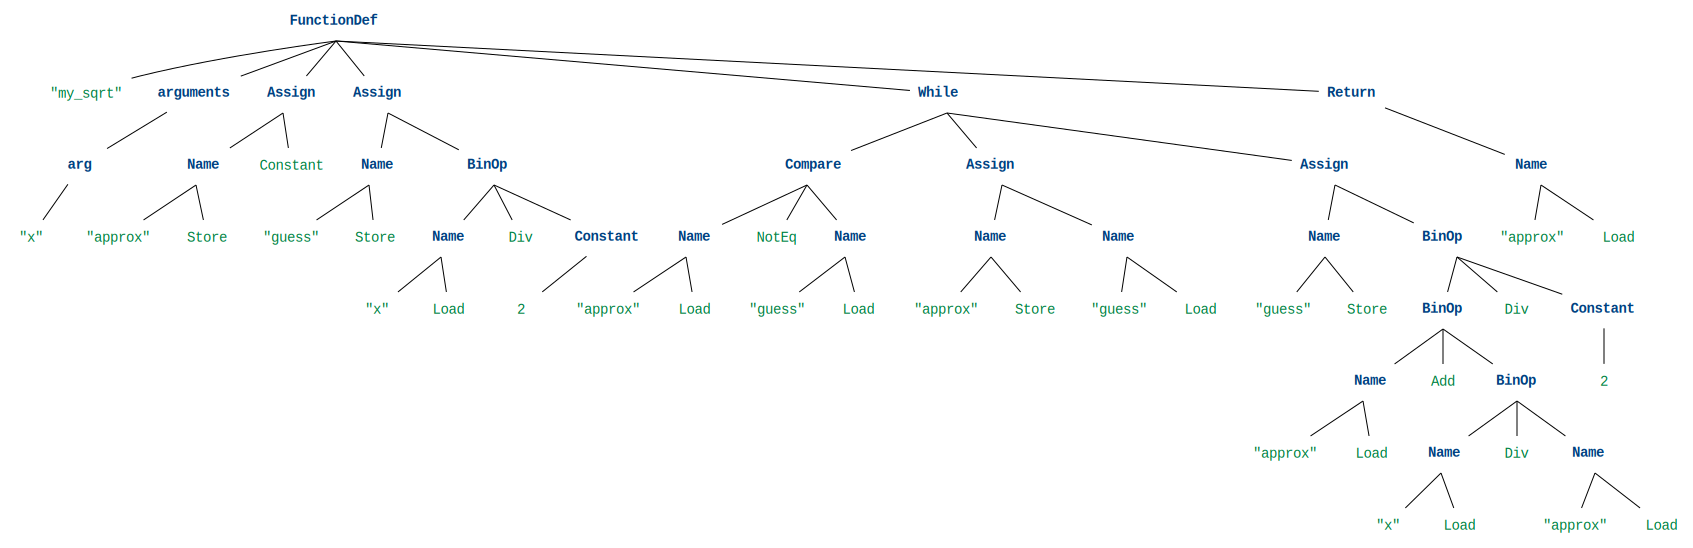

In [55]:
if rich_output():
    import showast
    showast.show_ast(my_sqrt_ast)

The function `ast.unparse()` converts such a tree back into the more familiar textual Python code representation.  Comments are gone, and there may be more parentheses than before, but the result has the same semantics:

In [56]:
print_content(ast.unparse(my_sqrt_ast), '.py')

def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

### Annotating Functions with Given Types

Let us now go and transform these trees ti add type annotations.  We start with a helper function `parse_type(name)` which  parses a type name into an AST.

In [57]:
def parse_type(name):
    class ValueVisitor(ast.NodeVisitor):
        def visit_Expr(self, node):
            self.value_node = node.value

    tree = ast.parse(name)
    name_visitor = ValueVisitor()
    name_visitor.visit(tree)
    return name_visitor.value_node

In [58]:
print(ast.dump(parse_type('int')))

Name(id='int', ctx=Load())


In [59]:
print(ast.dump(parse_type('[object]')))

List(elts=[Name(id='object', ctx=Load())], ctx=Load())


We now define a helper function that actually adds type annotations to a function AST.  The `TypeTransformer` class builds on the Python standard library `ast.NodeTransformer` infrastructure.  It would be called as

```python
    TypeTransformer({'x': 'int'}, 'float').visit(ast)
```

to annotate the arguments of `my_sqrt()`: `x` with `int`, and the return type with `float`.  The returned AST can then be unparsed, compiled or analyzed.

In [60]:
class TypeTransformer(ast.NodeTransformer):
    def __init__(self, argument_types, return_type=None):
        self.argument_types = argument_types
        self.return_type = return_type
        super().__init__()

The core of `TypeTransformer` is the method `visit_FunctionDef()`, which is called for every function definition in the AST.  Its argument `node` is the subtree of the function definition to be transformed.  Our implementation accesses the individual arguments and invokes `annotate_args()` on them; it also sets the return type in the `returns` attribute of the node.

In [61]:
class TypeTransformer(TypeTransformer):
    def visit_FunctionDef(self, node):
        """Add annotation to function"""
        # Set argument types
        new_args = []
        for arg in node.args.args:
            new_args.append(self.annotate_arg(arg))

        new_arguments = ast.arguments(
            node.args.posonlyargs,
            new_args,
            node.args.vararg,
            node.args.kwonlyargs,
            node.args.kw_defaults,
            node.args.kwarg,
            node.args.defaults
        )

        # Set return type
        if self.return_type is not None:
            node.returns = parse_type(self.return_type)

        return ast.copy_location(
            ast.FunctionDef(node.name, new_arguments, 
                            node.body, node.decorator_list,
                            node.returns), node)

Each argument gets its own annotation, taken from the types originally passed to the class:

In [62]:
class TypeTransformer(TypeTransformer):
    def annotate_arg(self, arg):
        """Add annotation to single function argument"""
        arg_name = arg.arg
        if arg_name in self.argument_types:
            arg.annotation = parse_type(self.argument_types[arg_name])
        return arg

Does this work?  Let us annotate the AST from `my_sqrt()` with types for the arguments and return types:

In [63]:
new_ast = TypeTransformer({'x': 'int'}, 'float').visit(my_sqrt_ast)

When we unparse the new AST, we see that the annotations actually are present:

In [64]:
print_content(ast.unparse(new_ast), '.py')

def my_sqrt(x: int) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

Similarly, we can annotate the `hello()` function from above:

In [65]:
hello_source = inspect.getsource(hello)

In [66]:
hello_ast = ast.parse(hello_source)

In [67]:
new_ast = TypeTransformer({'name': 'str'}, 'None').visit(hello_ast)

In [68]:
print_content(ast.unparse(new_ast), '.py')

def hello(name: str) -> None:
    print('Hello,', name)

### Annotating Functions with Mined Types

Let us now annotate functions with types mined at runtime. We start with a simple function `type_string()` that determines 
the appropriate type of a given value (as a string):

In [69]:
def type_string(value):
    return type(value).__name__

In [70]:
type_string(4)

'int'

In [71]:
type_string([])

'list'

For composite structures, `type_string()` does not examine element types; hence, the type of `[3]` is simply `list` instead of, say, `list[int]`.  For now, `list` will do fine.

In [72]:
type_string([3])

'list'

`type_string()` will be used to infer the types of argument values found at runtime, as returned by `CallTracker.calls()`:

In [73]:
with CallTracker() as tracker:
    y = my_sqrt(25.0)
    y = my_sqrt(2.0)

In [74]:
tracker.calls()

{'my_sqrt': [([('x', 25.0)], 5.0), ([('x', 2.0)], 1.414213562373095)]}

The function `annotate_types()` takes such a list of calls and annotates each function listed:

In [75]:
def annotate_types(calls):
    annotated_functions = {}
    
    for function_name in calls:
        try:
            annotated_functions[function_name] = annotate_function_with_types(function_name, calls[function_name])
        except KeyError:
            continue

    return annotated_functions

For each function, we get the source and its AST and then get to the actual annotation in `annotate_function_ast_with_types()`:

In [76]:
def annotate_function_with_types(function_name, function_calls):
    function = globals()[function_name]  # May raise KeyError for internal functions
    function_code = inspect.getsource(function)
    function_ast = ast.parse(function_code)
    return annotate_function_ast_with_types(function_ast, function_calls)

The function `annotate_function_ast_with_types()` invokes the `TypeTransformer` with the calls seen, and for each call, iterate over the arguments, determine their types, and annotate the AST with these.  The universal type `Any` is used when we encounter type conflicts, which we will discuss below.

In [77]:
from typing import Any

In [78]:
def annotate_function_ast_with_types(function_ast, function_calls):
    parameter_types = {}
    return_type = None

    for calls_seen in function_calls:
        args, return_value = calls_seen
        if return_value is not None:
            if return_type is not None and return_type != type_string(return_value):
                return_type = 'Any'
            else:
                return_type = type_string(return_value)
            
            
        for parameter, value in args:
            try:
                different_type = parameter_types[parameter] != type_string(value)
            except KeyError:
                different_type = False
                
            if different_type:
                parameter_types[parameter] = 'Any'
            else:
                parameter_types[parameter] = type_string(value)
        
    annotated_function_ast = TypeTransformer(parameter_types, return_type).visit(function_ast)
    return annotated_function_ast

Here is `my_sqrt()` annotated with the types recorded usign the tracker, above.

In [79]:
print_content(ast.unparse(annotate_types(tracker.calls())['my_sqrt']), '.py')

def my_sqrt(x: float) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

### All-in-one Annotation

Let us bring all of this together in a single class `TypeAnnotator` that first tracks calls of functions and then allows to access the AST (and the source code form) of the tracked functions annotated with types.  The method `typed_functions()` returns the annotated functions as a string; `typed_functions_ast()` returns their AST.

In [80]:
class TypeTracker(CallTracker):
    pass

In [81]:
class TypeAnnotator(TypeTracker):
    def typed_functions_ast(self, function_name=None):
        if function_name is None:
            return annotate_types(self.calls())

        return annotate_function_with_types(function_name, 
                                            self.calls(function_name))

    def typed_functions(self, function_name=None):
        if function_name is None:
            functions = ''
            for f_name in self.calls():
                try:
                    f_text = ast.unparse(self.typed_functions_ast(f_name))
                except KeyError:
                    f_text = ''
                functions += f_text
            return functions

        return ast.unparse(self.typed_functions_ast(function_name))

Here is how to use `TypeAnnotator`.  We first track a series of calls:

In [82]:
with TypeAnnotator() as annotator:
    y = my_sqrt(25.0)
    y = my_sqrt(2.0)

After tracking, we can immediately retrieve an annotated version of the functions tracked:

In [83]:
print_content(annotator.typed_functions(), '.py')

def my_sqrt(x: float) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

This also works for multiple and diverse functions.  One could go and implement an automatic type annotator for Python files based on the types seen during execution.

In [84]:
with TypeAnnotator() as annotator:
    hello('type annotations')
    y = my_sqrt(1.0)

Hello, type annotations


In [85]:
print_content(annotator.typed_functions(), '.py')

def hello(name: str):
    print('Hello,', name)def my_sqrt(x: float) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

A content as above could now be sent to a type checker, which would detect any type inconsistency between callers and callees.  Likewise, type annotations such as the ones above greatly benefit symbolic code analysis (as in the chapter on [symbolic fuzzing](SymbolicFuzzer.ipynb)), as they effectively constrain the set of values that arguments and variables can take.

### Multiple Types

Let us now resolve the role of the magic `Any` type in `annotate_function_ast_with_types()`.  If we see multiple types for the same argument, we set its type to `Any`.  For `my_sqrt()`, this makes sense, as its arguments can be integers as well as floats:

In [86]:
with CallTracker() as tracker:
    y = my_sqrt(25.0)
    y = my_sqrt(4)

In [87]:
print_content(ast.unparse(annotate_types(tracker.calls())['my_sqrt']), '.py')

def my_sqrt(x: Any) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

The following function `sum3()` can be called with floating-point numbers as arguments, resulting in the parameters getting a `float` type:

In [88]:
def sum3(a, b, c):
    return a + b + c

In [89]:
with TypeAnnotator() as annotator:
    y = sum3(1.0, 2.0, 3.0)
y

6.0

In [90]:
print_content(annotator.typed_functions(), '.py')

def sum3(a: float, b: float, c: float) -> float:
    return a + b + c

If we call `sum3()` with integers, though, the arguments get an `int` type:

In [91]:
with TypeAnnotator() as annotator:
    y = sum3(1, 2, 3)
y

6

In [92]:
print_content(annotator.typed_functions(), '.py')

def sum3(a: int, b: int, c: int) -> int:
    return a + b + c

And we can also call `sum3()` with strings, giving the arguments a `str` type:

In [93]:
with TypeAnnotator() as annotator:
    y = sum3("one", "two", "three")
y

'onetwothree'

In [94]:
print_content(annotator.typed_functions(), '.py')

def sum3(a: str, b: str, c: str) -> str:
    return a + b + c

If we have multiple calls, but with different types, `TypeAnnotator()` will assign an `Any` type to both arguments and return values:

In [95]:
with TypeAnnotator() as annotator:
    y = sum3(1, 2, 3)
    y = sum3("one", "two", "three")

In [96]:
typed_sum3_def = annotator.typed_functions('sum3')

In [97]:
print_content(typed_sum3_def, '.py')

def sum3(a: Any, b: Any, c: Any) -> Any:
    return a + b + c

A type `Any` makes it explicit that an object can, indeed, have any type; it will not be typechecked at runtime or statically.  To some extent, this defeats the power of type checking; but it also preserves some of the type flexibility that many Python programmers enjoy.  Besides `Any`, the `typing` module supports several additional ways to define ambiguous types; we will keep this in mind for a later exercise.

## Specifying and Checking Invariants

Besides basic data types. we can check several further properties from arguments.  We can, for instance, whether an argument can be negative, zero, or positive; or that one argument should be smaller than the second; or that the result should be the sum of two arguments – properties that cannot be expressed in a (Python) type.

Such properties are called *invariants*, as they hold across all invocations of a function. Specifically, invariants come as _pre_- and _postconditions_ – conditions that always hold at the beginning and at the end of a function.  (There are also _data_ and _object_ invariants that express always-holding properties over the state of data or objects, but we do not consider these in this book.)

### Annotating Functions with Pre- and Postconditions

The classical means to specify pre- and postconditions is via _assertions_, which we have introduced in the [chapter on testing](Intro_Testing.ipynb).  A precondition checks whether the arguments to a function satisfy the expected properties; a postcondition does the same for the result.  We can express and check both using assertions as follows:

In [98]:
def my_sqrt_with_invariants(x):
    assert x >= 0  # Precondition
    
    ...
    
    assert result * result == x  # Postcondition
    return result

A nicer way, however, is to syntactically separate invariants from the function at hand.  Using appropriate decorators, we could specify pre- and postconditions as follows:

```python
@precondition lambda x: x >= 0
@postcondition lambda return_value, x: return_value * return_value == x
def my_sqrt_with_invariants(x):
    # normal code without assertions
    ...
```

The decorators `@precondition` and `@postcondition` would run the given functions (specified as anonymous `lambda` functions) before and after the decorated function, respectively.  If the functions return `False`, the condition is violated.  `@precondition` gets the function arguments as arguments; `@postcondition` additionally gets the return value as first argument.

It turns out that implementing such decorators is not hard at all.  Our implementation builds on a [code snippet from StackOverflow](https://stackoverflow.com/questions/12151182/python-precondition-postcondition-for-member-function-how):

In [99]:
import functools

In [100]:
def condition(precondition=None, postcondition=None):
    def decorator(func):
        @functools.wraps(func) # preserves name, docstring, etc
        def wrapper(*args, **kwargs):
            if precondition is not None:
               assert precondition(*args, **kwargs), "Precondition violated"

            retval = func(*args, **kwargs) # call original function or method
            if postcondition is not None:
               assert postcondition(retval, *args, **kwargs), "Postcondition violated"

            return retval
        return wrapper
    return decorator

def precondition(check):
    return condition(precondition=check)

def postcondition(check):
    return condition(postcondition=check)

With these, we can now start decorating `my_sqrt()`:

In [101]:
@precondition(lambda x: x > 0)
def my_sqrt_with_precondition(x):
    return my_sqrt(x)

This catches arguments violating the precondition:

In [102]:
with ExpectError():
    my_sqrt_with_precondition(-1.0)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2353876897.py", line 2, in <cell line: 1>
    my_sqrt_with_precondition(-1.0)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 6, in wrapper
    assert precondition(*args, **kwargs), "Precondition violated"
AssertionError: Precondition violated (expected)


Likewise, we can provide a postcondition:

In [103]:
EPSILON = 1e-5

In [104]:
@postcondition(lambda ret, x: ret * ret - x < EPSILON)
def my_sqrt_with_postcondition(x):
    return my_sqrt(x)

In [105]:
y = my_sqrt_with_postcondition(2.0)
y

1.414213562373095

If we have a buggy implementation of $\sqrt{x}$, this gets caught quickly:

In [106]:
@postcondition(lambda ret, x: ret * ret - x < EPSILON)
def buggy_my_sqrt_with_postcondition(x):
    return my_sqrt(x) + 0.1

In [107]:
with ExpectError():
    y = buggy_my_sqrt_with_postcondition(2.0)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/1985029262.py", line 2, in <cell line: 1>
    y = buggy_my_sqrt_with_postcondition(2.0)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 10, in wrapper
    assert postcondition(retval, *args, **kwargs), "Postcondition violated"
AssertionError: Postcondition violated (expected)


While checking pre- and postconditions is a great way to catch errors, specifying them can be cumbersome.  Let us try to see whether we can (again) _mine_ some of them.

## Mining Invariants

To _mine_ invariants, we can use the same tracking functionality as before; instead of saving values for individual variables, though, we now check whether the values satisfy specific _properties_ or not.  For instance, if all values of `x` seen satisfy the condition `x > 0`, then we make `x > 0` an invariant of the function.  If we see positive, zero, and negative values of `x`, though, then there is no property of `x` left to talk about.

The general idea is thus:

1. Check all variable values observed against a set of predefined properties; and
2. Keep only those properties that hold for all runs observed.

### Defining Properties

What precisely do we mean by properties?  Here is a small collection of value properties that would frequently be used in invariants.  All these properties would be evaluated with the _metavariables_ `X`, `Y`, and `Z` (actually, any upper-case identifier) being replaced with the names of function parameters: 

In [108]:
INVARIANT_PROPERTIES = [
    "X < 0",
    "X <= 0",
    "X > 0",
    "X >= 0",
    "X == 0",
    "X != 0",
]

When `my_sqrt(x)` is called as, say `my_sqrt(5.0)`, we see that `x = 5.0` holds.  The above properties would then all be checked for `x`.  Only the properties `X > 0`, `X >= 0`, and `X != 0` hold for the call seen; and hence `x > 0`, `x >= 0`, and `x != 0` would make potential preconditions for `my_sqrt(x)`.

We can check for many more properties such as relations between two arguments:

In [109]:
INVARIANT_PROPERTIES += [
    "X == Y",
    "X > Y",
    "X < Y",
    "X >= Y",
    "X <= Y",
]

Types also can be checked using properties.  For any function parameter `X`, only one of these will hold:

In [110]:
INVARIANT_PROPERTIES += [
    "isinstance(X, bool)",
    "isinstance(X, int)",
    "isinstance(X, float)",
    "isinstance(X, list)",
    "isinstance(X, dict)",
]

We can check for arithmetic properties:

In [111]:
INVARIANT_PROPERTIES += [
    "X == Y + Z",
    "X == Y * Z",
    "X == Y - Z",
    "X == Y / Z",
]

Here's relations over three values, a Python special:

In [112]:
INVARIANT_PROPERTIES += [
    "X < Y < Z",
    "X <= Y <= Z",
    "X > Y > Z",
    "X >= Y >= Z",
]

Finally, we can also check for list or string properties.  Again, this is just a tiny selection.

In [113]:
INVARIANT_PROPERTIES += [
    "X == len(Y)",
    "X == sum(Y)",
    "X.startswith(Y)",
]

### Extracting Meta-Variables

Let us first introduce a few _helper functions_ before we can get to the actual mining.  `metavars()` extracts the set of meta-variables (`X`, `Y`, `Z`, etc.) from a property.  To this end, we parse the property as a Python expression and then visit the identifiers.

In [114]:
def metavars(prop):
    metavar_list = []
    
    class ArgVisitor(ast.NodeVisitor):
        def visit_Name(self, node):
            if node.id.isupper():
                metavar_list.append(node.id)

    ArgVisitor().visit(ast.parse(prop))
    return metavar_list

In [115]:
assert metavars("X < 0") == ['X']

In [116]:
assert metavars("X.startswith(Y)") == ['X', 'Y']

In [117]:
assert metavars("isinstance(X, str)") == ['X']

### Instantiating Properties

To produce a property as invariant, we need to be able to _instantiate_ it with variable names.  The instantiation of `X > 0` with `X` being instantiated to `a`, for instance, gets us `a > 0`.  To this end, the function `instantiate_prop()` takes a property and a collection of variable names and instantiates the meta-variables left-to-right with the corresponding variables names in the collection.

In [118]:
def instantiate_prop_ast(prop, var_names):
    class NameTransformer(ast.NodeTransformer):
        def visit_Name(self, node):
            if node.id not in mapping:
                return node
            return ast.Name(id=mapping[node.id], ctx=ast.Load())

    meta_variables = metavars(prop)
    assert len(meta_variables) == len(var_names)

    mapping = {}
    for i in range(0, len(meta_variables)):
        mapping[meta_variables[i]] = var_names[i]

    prop_ast = ast.parse(prop, mode='eval')
    new_ast = NameTransformer().visit(prop_ast)

    return new_ast

In [119]:
def instantiate_prop(prop, var_names):
    prop_ast = instantiate_prop_ast(prop, var_names)
    prop_text = ast.unparse(prop_ast).strip()
    while prop_text.startswith('(') and prop_text.endswith(')'):
        prop_text = prop_text[1:-1]
    return prop_text

In [120]:
assert instantiate_prop("X > Y", ['a', 'b']) == 'a > b'

In [121]:
assert instantiate_prop("X.startswith(Y)", ['x', 'y']) == 'x.startswith(y)'

### Evaluating Properties

To actually _evaluate_ properties, we do not need to instantiate them.  Instead, we simply convert them into a boolean function, using `lambda`:

In [122]:
def prop_function_text(prop):
    return "lambda " + ", ".join(metavars(prop)) + ": " + prop

def prop_function(prop):
    return eval(prop_function_text(prop))

Here is a simple example:

In [123]:
prop_function_text("X > Y")

'lambda X, Y: X > Y'

In [124]:
p = prop_function("X > Y")
p(100, 1)

True

In [125]:
p(1, 100)

False

### Checking Invariants

To extract invariants from an execution, we need to check them on all possible instantiations of arguments.  If the function to be checked has two arguments `a` and `b`, we instantiate the property `X < Y` both as `a < b` and `b < a` and check each of them.

To get all combinations, we use the Python `permutations()` function:

In [126]:
import itertools

In [127]:
for combination in itertools.permutations([1.0, 2.0, 3.0], 2):
    print(combination)

(1.0, 2.0)
(1.0, 3.0)
(2.0, 1.0)
(2.0, 3.0)
(3.0, 1.0)
(3.0, 2.0)


The function `true_property_instantiations()` takes a property and a list of tuples (`var_name`, `value`).  It then produces all instantiations of the property with the given values and returns those that evaluate to True.

In [128]:
def true_property_instantiations(prop, vars_and_values, log=False):
    instantiations = set()
    p = prop_function(prop)

    len_metavars = len(metavars(prop))
    for combination in itertools.permutations(vars_and_values, len_metavars):
        args = [value for var_name, value in combination]
        var_names = [var_name for var_name, value in combination]

        try:
            result = p(*args)
        except:
            result = None

        if log:
            print(prop, combination, result)
        if result:
            instantiations.add((prop, tuple(var_names)))

    return instantiations

Here is an example.   If `x == -1` and `y == 1`, the property `X < Y` holds for `x < y`, but not for `y < x`:

In [129]:
invs = true_property_instantiations("X < Y", [('x', -1), ('y', 1)], log=True)
invs

X < Y (('x', -1), ('y', 1)) True
X < Y (('y', 1), ('x', -1)) False


{('X < Y', ('x', 'y'))}

The instantiation retrieves the short form:

In [130]:
for prop, var_names in invs:
    print(instantiate_prop(prop, var_names))

x < y


Likewise, with values for `x` and `y` as above, the property `X < 0` only holds for `x`, but not for `y`:

In [131]:
invs = true_property_instantiations("X < 0", [('x', -1), ('y', 1)], log=True)

X < 0 (('x', -1),) True
X < 0 (('y', 1),) False


In [132]:
for prop, var_names in invs:
    print(instantiate_prop(prop, var_names))

x < 0


### Extracting Invariants

Let us now run the above invariant extraction on function arguments and return values as observed during a function execution.  To this end, we extend the `CallTracker` class into an `InvariantTracker` class, which automatically computes invariants for all functions and all calls observed during tracking.

By default, an `InvariantTracker` uses the properties as defined above; however, one can specify alternate sets of properties.

In [133]:
class InvariantTracker(CallTracker):
    def __init__(self, props=None, **kwargs):
        if props is None:
            props = INVARIANT_PROPERTIES

        self.props = props
        super().__init__(**kwargs)

The key method of the `InvariantTracker` is the `invariants()` method.  This iterates over the calls observed and checks which properties hold.  Only the intersection of properties – that is, the set of properties that hold for all calls – is preserved, and eventually returned.  The special variable `return_value` is set to hold the return value.

In [134]:
RETURN_VALUE = 'return_value'

In [135]:
class InvariantTracker(InvariantTracker):
    def invariants(self, function_name=None):
        if function_name is None:
            return {function_name: self.invariants(function_name) for function_name in self.calls()}

        invariants = None
        for variables, return_value in self.calls(function_name):
            vars_and_values = variables + [(RETURN_VALUE, return_value)]

            s = set()
            for prop in self.props:
                s |= true_property_instantiations(prop, vars_and_values, self._log)
            if invariants is None:
                invariants = s
            else:
                invariants &= s

        return invariants

Here's an example of how to use `invariants()`.  We run the tracker on a small set of calls.

In [136]:
with InvariantTracker() as tracker:
    y = my_sqrt(25.0)
    y = my_sqrt(10.0)

tracker.calls()

{'my_sqrt': [([('x', 25.0)], 5.0), ([('x', 10.0)], 3.162277660168379)]}

The `invariants()` method produces a set of properties that hold for the observed runs, together with their instantiations over function arguments.

In [137]:
invs = tracker.invariants('my_sqrt')
invs

{('X != 0', ('return_value',)),
 ('X != 0', ('x',)),
 ('X < Y', ('return_value', 'x')),
 ('X <= Y', ('return_value', 'x')),
 ('X > 0', ('return_value',)),
 ('X > 0', ('x',)),
 ('X > Y', ('x', 'return_value')),
 ('X >= 0', ('return_value',)),
 ('X >= 0', ('x',)),
 ('X >= Y', ('x', 'return_value')),
 ('isinstance(X, float)', ('return_value',)),
 ('isinstance(X, float)', ('x',))}

As before, the actual instantiations are easier to read:


In [138]:
def pretty_invariants(invariants):
    props = []
    for (prop, var_names) in invariants:
        props.append(instantiate_prop(prop, var_names))
    return sorted(props)

In [139]:
pretty_invariants(invs)

['isinstance(return_value, float)',
 'isinstance(x, float)',
 'return_value != 0',
 'return_value < x',
 'return_value <= x',
 'return_value > 0',
 'return_value >= 0',
 'x != 0',
 'x > 0',
 'x > return_value',
 'x >= 0',
 'x >= return_value']

We see that the both `x` and the return value have a `float` type.  We also see that both are always greater than zero.  These are properties that may make useful pre- and postconditions, notably for symbolic analysis.

However, there's also an invariant which does _not_ universally hold, namely `return_value <= x`, as the following example shows:

In [140]:
my_sqrt(0.01)

0.1

Clearly, 0.1 > 0.01 holds.  This is a case of us not learning from sufficiently diverse inputs.  As soon as we have a call including `x = 0.1`, though, the invariant `return_value <= x` is eliminated:

In [141]:
with InvariantTracker() as tracker:
    y = my_sqrt(25.0)
    y = my_sqrt(10.0)
    y = my_sqrt(0.01)
    
pretty_invariants(tracker.invariants('my_sqrt'))

['isinstance(return_value, float)',
 'isinstance(x, float)',
 'return_value != 0',
 'return_value > 0',
 'return_value >= 0',
 'x != 0',
 'x > 0',
 'x >= 0']

We will discuss later how to ensure sufficient diversity in inputs.  (Hint: This involves test generation.)

Let us try out our invariant tracker on `sum3()`.  We see that all types are well-defined; the properties that all arguments are non-zero, however, is specific to the calls observed.

In [142]:
with InvariantTracker() as tracker:
    y = sum3(1, 2, 3)
    y = sum3(-4, -5, -6)
    
pretty_invariants(tracker.invariants('sum3'))

['a != 0',
 'b != 0',
 'c != 0',
 'isinstance(a, int)',
 'isinstance(b, int)',
 'isinstance(c, int)',
 'isinstance(return_value, int)',
 'return_value != 0']

If we invoke `sum3()` with strings instead, we get different invariants.  Notably, we obtain the postcondition that the return value starts with the value of `a` – a universal postcondition if strings are used.

In [143]:
with InvariantTracker() as tracker:
    y = sum3('a', 'b', 'c')
    y = sum3('f', 'e', 'd')
    
pretty_invariants(tracker.invariants('sum3'))

['a != 0',
 'a < return_value',
 'a <= return_value',
 'b != 0',
 'c != 0',
 'return_value != 0',
 'return_value > a',
 'return_value >= a',
 'return_value.startswith(a)']

If we invoke `sum3()` with both strings and numbers (and zeros, too), there are no properties left that would hold across all calls.  That's the price of flexibility.

In [144]:
with InvariantTracker() as tracker:
    y = sum3('a', 'b', 'c')
    y = sum3('c', 'b', 'a')
    y = sum3(-4, -5, -6)
    y = sum3(0, 0, 0)
    
pretty_invariants(tracker.invariants('sum3'))

[]

### Converting Mined Invariants to Annotations

As with types, above, we would like to have some functionality where we can add the mined invariants as annotations to existing functions.  To this end, we introduce the `InvariantAnnotator` class, extending `InvariantTracker`.

We start with a helper method.  `params()` returns a comma-separated list of parameter names as observed during calls.

In [145]:
class InvariantAnnotator(InvariantTracker):
    def params(self, function_name):
        arguments, return_value = self.calls(function_name)[0]
        return ", ".join(arg_name for (arg_name, arg_value) in arguments)

In [146]:
with InvariantAnnotator() as annotator:
    y = my_sqrt(25.0)
    y = sum3(1, 2, 3)

In [147]:
annotator.params('my_sqrt')

'x'

In [148]:
annotator.params('sum3')

'c, b, a'

Now for the actual annotation.  `preconditions()` returns the preconditions from the mined invariants (i.e., those propertes that do not depend on the return value) as a string with annotations:

In [149]:
class InvariantAnnotator(InvariantAnnotator):
    def preconditions(self, function_name):
        conditions = []

        for inv in pretty_invariants(self.invariants(function_name)):
            if inv.find(RETURN_VALUE) >= 0:
                continue  # Postcondition

            cond = "@precondition(lambda " + self.params(function_name) + ": " + inv + ")"
            conditions.append(cond)

        return conditions

In [150]:
with InvariantAnnotator() as annotator:
    y = my_sqrt(25.0)
    y = my_sqrt(0.01)
    y = sum3(1, 2, 3)

In [151]:
annotator.preconditions('my_sqrt')

['@precondition(lambda x: isinstance(x, float))',
 '@precondition(lambda x: x != 0)',
 '@precondition(lambda x: x > 0)',
 '@precondition(lambda x: x >= 0)']

`postconditions()` does the same for postconditions:

In [152]:
class InvariantAnnotator(InvariantAnnotator):
    def postconditions(self, function_name):
        conditions = []

        for inv in pretty_invariants(self.invariants(function_name)):
            if inv.find(RETURN_VALUE) < 0:
                continue  # Precondition

            cond = ("@postcondition(lambda " + 
                RETURN_VALUE + ", " + self.params(function_name) + ": " + inv + ")")
            conditions.append(cond)

        return conditions

In [153]:
with InvariantAnnotator() as annotator:
    y = my_sqrt(25.0)
    y = my_sqrt(0.01)
    y = sum3(1, 2, 3)

In [154]:
annotator.postconditions('my_sqrt')

['@postcondition(lambda return_value, x: isinstance(return_value, float))',
 '@postcondition(lambda return_value, x: return_value != 0)',
 '@postcondition(lambda return_value, x: return_value > 0)',
 '@postcondition(lambda return_value, x: return_value >= 0)']

With these, we can take a function and add both pre- and postconditions as annotations:

In [155]:
class InvariantAnnotator(InvariantAnnotator):
    def functions_with_invariants(self):
        functions = ""
        for function_name in self.invariants():
            try:
                function = self.function_with_invariants(function_name)
            except KeyError:
                continue
            functions += function
        return functions

    def function_with_invariants(self, function_name):
        function = globals()[function_name]  # Can throw KeyError
        source = inspect.getsource(function)
        return "\n".join(self.preconditions(function_name) + 
                         self.postconditions(function_name)) + '\n' + source

Here comes `function_with_invariants()` in all its glory:

In [156]:
with InvariantAnnotator() as annotator:
    y = my_sqrt(25.0)
    y = my_sqrt(0.01)
    y = sum3(1, 2, 3)

In [157]:
print_content(annotator.function_with_invariants('my_sqrt'), '.py')

@precondition(lambda x: isinstance(x, float))
@precondition(lambda x: x != 0)
@precondition(lambda x: x > 0)
@precondition(lambda x: x >= 0)
@postcondition(lambda return_value, x: isinstance(return_value, float))
@postcondition(lambda return_value, x: return_value != 0)
@postcondition(lambda return_value, x: return_value > 0)
@postcondition(lambda return_value, x: return_value >= 0)
def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

Quite a lot of invariants, is it?  Further below (and in the exercises), we will discuss on how to focus on the most relevant properties.

### Some Examples

Here's another example.  `list_length()` recursively computes the length of a Python function.  Let us see whether we can mine its invariants:

In [158]:
def list_length(L):
    if L == []:
        length = 0
    else:
        length = 1 + list_length(L[1:])
    return length

In [159]:
with InvariantAnnotator() as annotator:
    length = list_length([1, 2, 3])

print_content(annotator.functions_with_invariants(), '.py')

@precondition(lambda L: L != 0)
@precondition(lambda L: isinstance(L, list))
@postcondition(lambda return_value, L: isinstance(return_value, int))
@postcondition(lambda return_value, L: return_value == len(L))
@postcondition(lambda return_value, L: return_value >= 0)
def list_length(L):
    if L == []:
        length = 0
    else:
        length = 1 + list_length(L[1:])
    return length

Almost all these properties (except for the very first) are relevant.  Of course, the reason the invariants are so neat is that the return value is equal to `len(L)` is that `X == len(Y)` is part of the list of properties to be checked.

The next example is a very simple function:

In [160]:
def sum2(a, b):
    return a + b

In [161]:
with InvariantAnnotator() as annotator:
    sum2(31, 45)
    sum2(0, 0)
    sum2(-1, -5)

The invariants all capture the relationship between `a`, `b`, and the return value as `return_value == a + b` in all its variations.

In [162]:
print_content(annotator.functions_with_invariants(), '.py')

@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: a == return_value - b)
@postcondition(lambda return_value, b, a: b == return_value - a)
@postcondition(lambda return_value, b, a: isinstance(return_value, int))
@postcondition(lambda return_value, b, a: return_value == a + b)
@postcondition(lambda return_value, b, a: return_value == b + a)
def sum2(a, b):
    return a + b

If we have a function without return value, the return value is `None` and we can only mine preconditions.  (Well, we get a "postcondition" that the return value is non-zero, which holds for `None`).

In [163]:
def print_sum(a, b):
    print(a + b)

In [164]:
with InvariantAnnotator() as annotator:
    print_sum(31, 45)
    print_sum(0, 0)
    print_sum(-1, -5)

76
0
-6


In [165]:
print_content(annotator.functions_with_invariants(), '.py')

@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: return_value != 0)
def print_sum(a, b):
    print(a + b)

### Checking Specifications

A function with invariants, as above, can be fed into the Python interpreter, such that all pre- and postconditions are checked.  We create a function `my_sqrt_annotated()` which includes all the invariants mined above.

In [166]:
with InvariantAnnotator() as annotator:
    y = my_sqrt(25.0)
    y = my_sqrt(0.01)

In [167]:
my_sqrt_def = annotator.functions_with_invariants()
my_sqrt_def = my_sqrt_def.replace('my_sqrt', 'my_sqrt_annotated')

In [168]:
print_content(my_sqrt_def, '.py')

@precondition(lambda x: isinstance(x, float))
@precondition(lambda x: x != 0)
@precondition(lambda x: x > 0)
@precondition(lambda x: x >= 0)
@postcondition(lambda return_value, x: isinstance(return_value, float))
@postcondition(lambda return_value, x: return_value != 0)
@postcondition(lambda return_value, x: return_value > 0)
@postcondition(lambda return_value, x: return_value >= 0)
def my_sqrt_annotated(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

In [169]:
exec(my_sqrt_def)

The "annotated" version checks against invalid arguments – or more precisely, against arguments with properties that have not been observed yet:

In [170]:
with ExpectError():
    my_sqrt_annotated(-1.0)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/3390953352.py", line 2, in <cell line: 1>
    my_sqrt_annotated(-1.0)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 8, in wrapper
    retval = func(*args, **kwargs) # call original function or method
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 8, in wrapper
    retval = func(*args, **kwargs) # call original function or method
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 6, in wrapper
    assert precondition(*args, **kwargs), "Precondition violated"
AssertionError: Precondition violated (expected)


This is in contrast to the original version, which just hangs on negative values:

In [171]:
with ExpectTimeout(1):
    my_sqrt(-1.0)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2605599394.py", line 2, in <cell line: 1>
    my_sqrt(-1.0)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2661069967.py", line 7, in my_sqrt
    guess = (approx + x / approx) / 2
  File "/Users/zeller/Projects/fuzzingbook/notebooks/Timeout.ipynb", line 43, in timeout_handler
    raise TimeoutError()
TimeoutError (expected)


If we make changes to the function definition such that the properties of the return value change, such _regressions_ are caught as violations of the postconditions.  Let us illustrate this by simply inverting the result, and return $-2$ as square root of 4.

In [172]:
my_sqrt_def = my_sqrt_def.replace('my_sqrt_annotated', 'my_sqrt_negative')
my_sqrt_def = my_sqrt_def.replace('return approx', 'return -approx')

In [173]:
print_content(my_sqrt_def, '.py')

@precondition(lambda x: isinstance(x, float))
@precondition(lambda x: x != 0)
@precondition(lambda x: x > 0)
@precondition(lambda x: x >= 0)
@postcondition(lambda return_value, x: isinstance(return_value, float))
@postcondition(lambda return_value, x: return_value != 0)
@postcondition(lambda return_value, x: return_value > 0)
@postcondition(lambda return_value, x: return_value >= 0)
def my_sqrt_negative(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return -approx

In [174]:
exec(my_sqrt_def)

Technically speaking, $-2$ _is_ a square root of 4, since $(-2)^2 = 4$ holds.  Yet, such a change may be unexpected by callers of `my_sqrt()`, and hence, this would be caught with the first call:

In [175]:
with ExpectError():
    my_sqrt_negative(2.0)  # type: ignore

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2428286732.py", line 2, in <cell line: 1>
    my_sqrt_negative(2.0)  # type: ignore
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 8, in wrapper
    retval = func(*args, **kwargs) # call original function or method
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 8, in wrapper
    retval = func(*args, **kwargs) # call original function or method
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 8, in wrapper
    retval = func(*args, **kwargs) # call original function or method
  [Previous line repeated 4 more times]
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 10, in wrapper
    assert postcondition(retval, *args, **kwargs), "Postcondition violated"
AssertionError: Postcondition violated (expected)


We see how pre- and postconditions, as well as types, can serve as *oracles* during testing.  In particular, once we have mined them for a set of functions, we can check them again and again with test generators – especially after code changes.  The more checks we have, and the more specific they are, the more likely it is we can detect unwanted effects of changes.

## Mining Specifications from Generated Tests

Mined specifications can only be as good as the executions they were mined from.  If we only see a single call to, say, `sum2()` as defined above, we will be faced with several mined pre- and postconditions that _overspecialize_ towards the values seen:

In [176]:
with InvariantAnnotator() as annotator:
    y = sum2(2, 2)
print_content(annotator.functions_with_invariants(), '.py')

@precondition(lambda b, a: a != 0)
@precondition(lambda b, a: a <= b)
@precondition(lambda b, a: a == b)
@precondition(lambda b, a: a > 0)
@precondition(lambda b, a: a >= 0)
@precondition(lambda b, a: a >= b)
@precondition(lambda b, a: b != 0)
@precondition(lambda b, a: b <= a)
@precondition(lambda b, a: b == a)
@precondition(lambda b, a: b > 0)
@precondition(lambda b, a: b >= 0)
@precondition(lambda b, a: b >= a)
@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: a < return_value)
@postcondition(lambda return_value, b, a: a <= b <= return_value)
@postcondition(lambda return_value, b, a: a <= return_value)
@postcondition(lambda return_value, b, a: a == return_value - b)
@postcondition(lambda return_value, b, a: a == return_value / b)
@postcondition(lambda return_value, b, a: b < return_value)
@postcondition(lambda return_value, b, a: b <= a <= return_value)
@postcondition(lambda return_value, b, a: b <

The mined precondition `a == b`, for instance, only holds for the single call observed; the same holds for the mined postcondition `return_value == a * b`.  Yet, `sum2()` can obviously be successfully called with other values that do not satisfy these conditions.

To get out of this trap, we have to _learn from more and more diverse runs_.  If we have a few more calls of `sum2()`, we see how the set of invariants quickly gets smaller:

In [177]:
with InvariantAnnotator() as annotator:
    length = sum2(1, 2)
    length = sum2(-1, -2)
    length = sum2(0, 0)

print_content(annotator.functions_with_invariants(), '.py')

@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: a == return_value - b)
@postcondition(lambda return_value, b, a: b == return_value - a)
@postcondition(lambda return_value, b, a: isinstance(return_value, int))
@postcondition(lambda return_value, b, a: return_value == a + b)
@postcondition(lambda return_value, b, a: return_value == b + a)
def sum2(a, b):
    return a + b

But where to we get such diverse runs from?  This is the job of generating software tests.  A simple grammar for calls of `sum2()` will easily resolve the problem.

In [178]:
from GrammarFuzzer import GrammarFuzzer  # minor dependency
from Grammars import is_valid_grammar, crange  # minor dependency
from Grammars import convert_ebnf_grammar, Grammar  # minor dependency

In [179]:
SUM2_EBNF_GRAMMAR: Grammar = {
    "<start>": ["<sum2>"],
    "<sum2>": ["sum2(<int>, <int>)"],
    "<int>": ["<_int>"],
    "<_int>": ["(-)?<leaddigit><digit>*", "0"],
    "<leaddigit>": crange('1', '9'),
    "<digit>": crange('0', '9')
}

In [180]:
assert is_valid_grammar(SUM2_EBNF_GRAMMAR)

In [181]:
sum2_grammar =  convert_ebnf_grammar(SUM2_EBNF_GRAMMAR)

In [182]:
sum2_fuzzer = GrammarFuzzer(sum2_grammar)
[sum2_fuzzer.fuzz() for i in range(10)]

['sum2(60, 3)',
 'sum2(-4, 0)',
 'sum2(-579, 34)',
 'sum2(3, 0)',
 'sum2(-8, 0)',
 'sum2(0, 8)',
 'sum2(3, -9)',
 'sum2(0, 0)',
 'sum2(0, 5)',
 'sum2(-3181, 0)']

In [183]:
with InvariantAnnotator() as annotator:
    for i in range(10):
        eval(sum2_fuzzer.fuzz())

print_content(annotator.function_with_invariants('sum2'), '.py')

@precondition(lambda b, a: a != 0)
@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: a == return_value - b)
@postcondition(lambda return_value, b, a: b == return_value - a)
@postcondition(lambda return_value, b, a: isinstance(return_value, int))
@postcondition(lambda return_value, b, a: return_value != 0)
@postcondition(lambda return_value, b, a: return_value == a + b)
@postcondition(lambda return_value, b, a: return_value == b + a)
def sum2(a, b):
    return a + b

But then, writing tests (or a test driver) just to derive a set of pre- and postconditions may possibly be too much effort – in particular, since tests can easily be derived from given pre- and postconditions in the first place.  Hence, it would be wiser to first specify invariants and then let test generators or program provers do the job.

Also, an API grammar, such as above, will have to be set up such that it actually respects preconditions – in our case, we invoke `sqrt()` with positive numbers only, already assuming its precondition.  In some way, one thus needs a specification (a model, a grammar) to mine another specification – a chicken-and-egg problem.

However, there is one way out of this problem: If one can automatically generate tests at the system level, then one has an _infinite source of executions_ to learn invariants from.  In each of these executions, all functions would be called with values that satisfy the (implicit) precondition, allowing us to mine invariants for these functions.  This holds, because at the system level, invalid inputs must be rejected by the system in the first place.  The meaningful precondition at the system level, ensuring that only valid inputs get through, thus gets broken down into a multitude of meaningful preconditions (and subsequent postconditions) at the function level.

The big requirement for this, though, is that one needs good test generators at the system level.  In [the next part](05_Domain-Specific_Fuzzing.ipynb), we will discuss how to automatically generate tests for a variety of domains, from configuration to graphical user interfaces.

## Synopsis

This chapter provides two classes that automatically extract specifications from a function and a set of inputs:

* `TypeAnnotator` for _types_, and
* `InvariantAnnotator` for _pre-_ and _postconditions_.

Both work by _observing_ a function and its invocations within a `with` clause.  Here is an example for the type annotator:

In [184]:
def sum(a, b):
    return a + b

In [185]:
with TypeAnnotator() as type_annotator:
    sum(1, 2)
    sum(-4, -5)
    sum(0, 0)

The `typed_functions()` method will return a representation of `sum2()` annotated with types observed during execution.

In [186]:
print(type_annotator.typed_functions())

def sum(a: int, b: int) -> int:
    return a + b


The invariant annotator works in a similar fashion:

In [187]:
with InvariantAnnotator() as inv_annotator:
    sum(1, 2)
    sum(-4, -5)
    sum(0, 0)

The `functions_with_invariants()` method will return a representation of `sum2()` annotated with inferred pre- and postconditions that all hold for the observed values.

In [188]:
print(inv_annotator.functions_with_invariants())

@precondition(lambda b, a: isinstance(a, int))
@precondition(lambda b, a: isinstance(b, int))
@postcondition(lambda return_value, b, a: a == return_value - b)
@postcondition(lambda return_value, b, a: b == return_value - a)
@postcondition(lambda return_value, b, a: isinstance(return_value, int))
@postcondition(lambda return_value, b, a: return_value == a + b)
@postcondition(lambda return_value, b, a: return_value == b + a)
def sum(a, b):
    return a + b



Such type specifications and invariants can be helpful as _oracles_ (to detect deviations from a given set of runs) as well as for all kinds of _symbolic code analyses_.  The chapter gives details on how to customize the properties checked for.

## Lessons Learned

* Type annotations and explicit invariants allow for _checking_ arguments and results for expected data types and other properties.
* One can automatically _mine_ data types and invariants by observing arguments and results at runtime.
* The quality of mined invariants depends on the diversity of values observed during executions; this variety can be increased by generating tests.

## Next Steps

This chapter concludes the [part on semantical fuzzing techniques](04_Semantical_Fuzzing.ipynb).  In the next part, we will explore [domain-specific fuzzing techniques](05_Domain-Specific_Fuzzing.ipynb) from configurations and APIs to graphical user interfaces.

## Background

The [DAIKON dynamic invariant detector](https://plse.cs.washington.edu/daikon/) can be considered the mother of function specification miners.  Continuously maintained and extended for more than 20 years, it mines likely invariants in the style of this chapter for a variety of languages, including C, C++, C#, Eiffel, F#, Java, Perl, and Visual Basic.  On top of the functionality discussed above, it holds a rich catalog of patterns for likely invariants, supports data invariants, can eliminate invariants that are implied by others, and determines statistical confidence to disregard unlikely invariants.  The corresponding paper \cite{Ernst2001} is one of the seminal and most-cited papers of Software Engineering.  A multitude of works have been published based on DAIKON and detecting invariants; see this [curated list](http://plse.cs.washington.edu/daikon/pubs/) for details.

The interaction between test generators and invariant detection is already discussed in \cite{Ernst2001} (incidentally also using grammars).  The Eclat tool \cite{Pacheco2005} is a model example of tight interaction between a unit-level test generator and DAIKON-style invariant mining, where the mined invariants are used to produce oracles and to systematically guide the test generator towards fault-revealing inputs.

Mining specifications is not restricted to pre- and postconditions.  The paper "Mining Specifications" \cite{Ammons2002} is another classic in the field, learning state protocols from executions.  Grammar mining, as described in [our chapter with the same name](GrammarMiner.ipynb) can also be seen as a specification mining approach, this time learning specifications for input formats.

As it comes to adding type annotations to existing code, the blog post ["The state of type hints in Python"](https://www.bernat.tech/the-state-of-type-hints-in-python/) gives a great overview on how Python type hints can be used and checked.  To add type annotations, there are two important tools available that also implement our above approach:

* [MonkeyType](https://instagram-engineering.com/let-your-code-type-hint-itself-introducing-open-source-monkeytype-a855c7284881) implements the above approach of tracing executions and annotating Python 3 arguments, returns, and variables with type hints.
* [PyAnnotate](https://github.com/dropbox/pyannotate) does a similar job, focusing on code in Python 2.  It does not produce Python 3-style annotations, but instead produces annotations as comments that can be processed by static type checkers.

These tools have been created by engineers at Facebook and Dropbox, respectively, assisting them in checking millions of lines of code for type issues.

## Exercises

Our code for mining types and invariants is in no way complete.  There are dozens of ways to extend our implementations, some of which we discuss in exercises.

### Exercise 1: Union Types

The Python `typing` module allows to express that an argument can have multiple types.  For `my_sqrt(x)`, this allows to express that `x` can be an `int` or a `float`:

In [189]:
from typing import Union, Optional

In [190]:
def my_sqrt_with_union_type(x: Union[int, float]) -> float:
    ...

Extend the `TypeAnnotator` such that it supports union types for arguments and return values.  Use `Optional[X]` as a shorthand for `Union[X, None]`.

**Solution.** Left to the reader. Hint: extend `type_string()`.

### Exercise 2: Types for Local Variables

In Python, one cannot only annotate arguments with types, but actually also local and global variables – for instance, `approx` and `guess` in our `my_sqrt()` implementation:

In [191]:
def my_sqrt_with_local_types(x: Union[int, float]) -> float:
    """Computes the square root of x, using the Newton-Raphson method"""
    approx: Optional[float] = None
    guess: float = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

Extend the `TypeAnnotator` such that it also annotates local variables with types.  Search the function AST for assignments, determine the type of the assigned value, and make it an annotation on the left hand side.

**Solution.** Left to the reader.

### Exercise 3: Verbose Invariant Checkers

Our implementation of invariant checkers does not make it clear for the user which pre-/postcondition failed.

In [192]:
@precondition(lambda s: len(s) > 0)
def remove_first_char(s):
    return s[1:]

In [193]:
with ExpectError():
    remove_first_char('')

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2212034949.py", line 2, in <cell line: 1>
    remove_first_char('')
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/906718213.py", line 6, in wrapper
    assert precondition(*args, **kwargs), "Precondition violated"
AssertionError: Precondition violated (expected)


The following implementation adds an optional `doc` keyword argument which is printed if the invariant is violated:

In [194]:
def verbose_condition(precondition=None, postcondition=None, doc='Unknown'):
    def decorator(func):
        @functools.wraps(func) # preserves name, docstring, etc
        def wrapper(*args, **kwargs):
            if precondition is not None:
                assert precondition(*args, **kwargs), "Precondition violated: " + doc

            retval = func(*args, **kwargs) # call original function or method
            if postcondition is not None:
                assert postcondition(retval, *args, **kwargs), "Postcondition violated: " + doc

            return retval
        return wrapper
    return decorator

In [195]:
def verbose_precondition(check, **kwargs):  # type: ignore
    return verbose_condition(precondition=check, doc=kwargs.get('doc', 'Unknown'))

In [196]:
def verbose_postcondition(check, **kwargs):  # type: ignore
    return verbose_condition(postcondition=check, doc=kwargs.get('doc', 'Unknown'))

In [197]:
@verbose_precondition(lambda s: len(s) > 0, doc="len(s) > 0")  # type: ignore
def remove_first_char(s):
    return s[1:]

remove_first_char('abc')

'bc'

In [198]:
with ExpectError():
    remove_first_char('')

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/2212034949.py", line 2, in <cell line: 1>
    remove_first_char('')
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/860932556.py", line 6, in wrapper
    assert precondition(*args, **kwargs), "Precondition violated: " + doc
AssertionError: Precondition violated: len(s) > 0 (expected)


Extend `InvariantAnnotator` such that it includes the conditions in the generated pre- and postconditions.

**Solution.** Here's a simple solution:

In [199]:
class InvariantAnnotator(InvariantAnnotator):
    def preconditions(self, function_name):
        conditions = []

        for inv in pretty_invariants(self.invariants(function_name)):
            if inv.find(RETURN_VALUE) >= 0:
                continue  # Postcondition

            cond = "@verbose_precondition(lambda " + self.params(function_name) + ": " + inv + ', doc=' + repr(inv) + ")"
            conditions.append(cond)

        return conditions

In [200]:
class InvariantAnnotator(InvariantAnnotator):
    def postconditions(self, function_name):
        conditions = []

        for inv in pretty_invariants(self.invariants(function_name)):
            if inv.find(RETURN_VALUE) < 0:
                continue  # Precondition

            cond = ("@verbose_postcondition(lambda " + 
                RETURN_VALUE + ", " + self.params(function_name) + ": " + inv + ', doc=' + repr(inv) + ")")
            conditions.append(cond)

        return conditions

The resulting annotations are harder to read, but easier to diagnose:

In [201]:
with InvariantAnnotator() as annotator:
    y = sum2(2, 2)
print_content(annotator.functions_with_invariants(), '.py')

@verbose_precondition(lambda b, a: a != 0, doc='a != 0')
@verbose_precondition(lambda b, a: a <= b, doc='a <= b')
@verbose_precondition(lambda b, a: a == b, doc='a == b')
@verbose_precondition(lambda b, a: a > 0, doc='a > 0')
@verbose_precondition(lambda b, a: a >= 0, doc='a >= 0')
@verbose_precondition(lambda b, a: a >= b, doc='a >= b')
@verbose_precondition(lambda b, a: b != 0, doc='b != 0')
@verbose_precondition(lambda b, a: b <= a, doc='b <= a')
@verbose_precondition(lambda b, a: b == a, doc='b == a')
@verbose_precondition(lambda b, a: b > 0, doc='b > 0')
@verbose_precondition(lambda b, a: b >= 0, doc='b >= 0')
@verbose_precondition(lambda b, a: b >= a, doc='b >= a')
@verbose_precondition(lambda b, a: isinstance(a, int), doc='isinstance(a, int)')
@verbose_precondition(lambda b, a: isinstance(b, int), doc='isinstance(b, int)')
@verbose_postcondition(lambda return_value, b, a: a < return_value, doc='a < return_value')
@verbose_postcondition(lambda return_value, b, a: a <= b <= return

As an alternative, one may be able to use `inspect.getsource()` on the lambda expression or unparse it.  This is left to the reader.

### Exercise 4: Save Initial Values

If the value of an argument changes during function execution, this can easily confuse our implementation: The values are tracked at the beginning of the function, but checked only when it returns.  Extend the `InvariantAnnotator` and the infrastructure it uses such that

* it saves argument values both at the beginning and at the end of a function invocation;
* postconditions can be expressed over both _initial_ values of arguments as well as the _final_ values of arguments;
* the mined postconditions refer to both these values as well.

**Solution.** To be added.

### Exercise 5: Implications

Several mined invariant are actually _implied_ by others: If `x > 0` holds, then this implies `x >= 0` and `x != 0`.  Extend the `InvariantAnnotator` such that implications between properties are explicitly encoded, and such that implied properties are no longer listed as invariants.  See \cite{Ernst2001} for ideas.

**Solution.** Left to the reader.

### Exercise 6: Local Variables

Postconditions may also refer to the values of local variables.  Consider extending `InvariantAnnotator` and its infrastructure such that the values of local variables at the end of the execution are also recorded and made part of the invariant inference mechanism.

**Solution.** Left to the reader.

### Exercise 7: Exploring Invariant Alternatives

After mining a first set of invariants, have a [concolic fuzzer](ConcolicFuzzer.ipynb) generate tests that systematically attempt to invalidate pre- and postconditions.  How far can you generalize?

**Solution.** To be added.

### Exercise 8: Grammar-Generated Properties

The larger the set of properties to be checked, the more potential invariants can be discovered.  Create a _grammar_ that systematically produces a large set of properties.  See \cite{Ernst2001} for possible patterns.

**Solution.** Left to the reader.

### Exercise 9: Embedding Invariants as Assertions

Rather than producing invariants as annotations for pre- and postconditions, insert them as `assert` statements into the function code, as in:

```python
def my_sqrt(x):
    'Computes the square root of x, using the Newton-Raphson method'
    assert isinstance(x, int), 'violated precondition'
    assert (x > 0), 'violated precondition'
    approx = None
    guess = (x / 2)
    while (approx != guess):
        approx = guess
        guess = ((approx + (x / approx)) / 2)
    return_value = approx
    assert (return_value < x), 'violated postcondition'
    assert isinstance(return_value, float), 'violated postcondition'
    return approx
```

Such a formulation may make it easier for test generators and symbolic analysis to access and interpret pre- and postconditions.

**Solution.** Here is a tentative implementation that inserts invariants into function ASTs.

Part 1: Embedding Invariants into Functions

In [202]:
class EmbeddedInvariantAnnotator(InvariantTracker):
    def functions_with_invariants_ast(self, function_name=None):
        if function_name is None:
            return annotate_functions_with_invariants(self.invariants())
        
        return annotate_function_with_invariants(function_name, self.invariants(function_name))
    
    def functions_with_invariants(self, function_name=None):
        if function_name is None:
            functions = ''
            for f_name in self.invariants():
                try:
                    f_text = ast.unparse(self.functions_with_invariants_ast(f_name))
                except KeyError:
                    f_text = ''
                functions += f_text
            return functions

        return ast.unparse(self.functions_with_invariants_ast(function_name))
    
    def function_with_invariants(self, function_name):
        return self.functions_with_invariants(function_name)
    def function_with_invariants_ast(self, function_name):
        return self.functions_with_invariants_ast(function_name)

In [203]:
def annotate_invariants(invariants):
    annotated_functions = {}
    
    for function_name in invariants:
        try:
            annotated_functions[function_name] = annotate_function_with_invariants(function_name, invariants[function_name])
        except KeyError:
            continue

    return annotated_functions

In [204]:
def annotate_function_with_invariants(function_name, function_invariants):
    function = globals()[function_name]
    function_code = inspect.getsource(function)
    function_ast = ast.parse(function_code)
    return annotate_function_ast_with_invariants(function_ast, function_invariants)

In [205]:
def annotate_function_ast_with_invariants(function_ast, function_invariants):
    annotated_function_ast = EmbeddedInvariantTransformer(function_invariants).visit(function_ast)
    return annotated_function_ast

Part 2: Preconditions

In [206]:
class PreconditionTransformer(ast.NodeTransformer):
    def __init__(self, invariants):
        self.invariants = invariants
        super().__init__()

    def preconditions(self):
        preconditions = []
        for (prop, var_names) in self.invariants:
            assertion = "assert " + instantiate_prop(prop, var_names) + ', "violated precondition"'
            assertion_ast = ast.parse(assertion)

            if assertion.find(RETURN_VALUE) < 0:
                preconditions += assertion_ast.body

        return preconditions

    def insert_assertions(self, body):
        preconditions = self.preconditions()
        try:
            docstring = body[0].value.s
        except:
            docstring = None

        if docstring:
            return [body[0]] + preconditions + body[1:]
        else:
            return preconditions + body

    def visit_FunctionDef(self, node):
        """Add invariants to function"""
        # print(ast.dump(node))
        node.body = self.insert_assertions(node.body)
        return node    

In [207]:
class EmbeddedInvariantTransformer(PreconditionTransformer):
    pass

In [208]:
with EmbeddedInvariantAnnotator() as annotator:
    my_sqrt(5)

In [209]:
print_content(annotator.functions_with_invariants(), '.py')

def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    assert x > 0, 'violated precondition'
    assert x >= 0, 'violated precondition'
    assert isinstance(x, int), 'violated precondition'
    assert x != 0, 'violated precondition'
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return approx

In [210]:
with EmbeddedInvariantAnnotator() as annotator:
    y = sum3(3, 4, 5)
    y = sum3(-3, -4, -5)
    y = sum3(0, 0, 0)

In [211]:
print_content(annotator.functions_with_invariants(), '.py')

def sum3(a, b, c):
    assert isinstance(b, int), 'violated precondition'
    assert isinstance(c, int), 'violated precondition'
    assert isinstance(a, int), 'violated precondition'
    return a + b + c

Part 3: Postconditions

We make a few simplifying assumptions: 

* Variables do not change during execution.
* There is a single `return` statement at the end of the function.

In [212]:
class EmbeddedInvariantTransformer(PreconditionTransformer):
    def postconditions(self):
        postconditions = []

        for (prop, var_names) in self.invariants:
            assertion = "assert " + instantiate_prop(prop, var_names) + ', "violated postcondition"'
            assertion_ast = ast.parse(assertion)

            if assertion.find(RETURN_VALUE) >= 0:
                postconditions += assertion_ast.body

        return postconditions
    
    def insert_assertions(self, body):
        new_body = super().insert_assertions(body)
        postconditions = self.postconditions()

        body_ends_with_return = isinstance(new_body[-1], ast.Return)
        if body_ends_with_return:
            saver = RETURN_VALUE + " = " + ast.unparse(new_body[-1].value)
        else:
            saver = RETURN_VALUE + " = None"
    
        saver_ast = ast.parse(saver)
        postconditions = [saver_ast] + postconditions

        if body_ends_with_return:
            return new_body[:-1] + postconditions + [new_body[-1]]
        else:
            return new_body + postconditions

In [213]:
with EmbeddedInvariantAnnotator() as annotator:
    my_sqrt(5)

In [214]:
my_sqrt_def = annotator.functions_with_invariants()

Here's the full definition with included assertions:

In [215]:
print_content(my_sqrt_def, '.py')

def my_sqrt(x):
    """Computes the square root of x, using the Newton-Raphson method"""
    assert x > 0, 'violated precondition'
    assert x >= 0, 'violated precondition'
    assert isinstance(x, int), 'violated precondition'
    assert x != 0, 'violated precondition'
    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    return_value = approx
    assert return_value <= x, 'violated postcondition'
    assert return_value != 0, 'violated postcondition'
    assert x >= return_value, 'violated postcondition'
    assert return_value >= 0, 'violated postcondition'
    assert return_value < x, 'violated postcondition'
    assert return_value > 0, 'violated postcondition'
    assert isinstance(return_value, float), 'violated postcondition'
    assert x > return_value, 'violated postcondition'
    return approx

In [216]:
exec(my_sqrt_def.replace('my_sqrt', 'my_sqrt_annotated'))

In [217]:
with ExpectError():
    my_sqrt_annotated(-1)

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_64715/1337162511.py", line 2, in <cell line: 1>
    my_sqrt_annotated(-1)
  File "<string>", line 3, in my_sqrt_annotated
AssertionError: violated precondition (expected)


Here come some more examples:

In [218]:
with EmbeddedInvariantAnnotator() as annotator:
    y = sum3(3, 4, 5)
    y = sum3(-3, -4, -5)
    y = sum3(0, 0, 0)

In [219]:
print_content(annotator.functions_with_invariants(), '.py')

def sum3(a, b, c):
    assert isinstance(b, int), 'violated precondition'
    assert isinstance(c, int), 'violated precondition'
    assert isinstance(a, int), 'violated precondition'
    return_value = a + b + c
    assert isinstance(return_value, int), 'violated postcondition'
    return a + b + c

In [220]:
with EmbeddedInvariantAnnotator() as annotator:
    length = list_length([1, 2, 3])

print_content(annotator.functions_with_invariants(), '.py')

def list_length(L):
    assert L != 0, 'violated precondition'
    assert isinstance(L, list), 'violated precondition'
    if L == []:
        length = 0
    else:
        length = 1 + list_length(L[1:])
    return_value = length
    assert return_value >= 0, 'violated postcondition'
    assert return_value == len(L), 'violated postcondition'
    assert isinstance(return_value, int), 'violated postcondition'
    return length

In [221]:
with EmbeddedInvariantAnnotator() as annotator:
    print_sum(31, 45)

76


In [222]:
print_content(annotator.functions_with_invariants(), '.py')

def print_sum(a, b):
    assert isinstance(b, int), 'violated precondition'
    assert a <= b, 'violated precondition'
    assert b != 0, 'violated precondition'
    assert a > 0, 'violated precondition'
    assert b >= a, 'violated precondition'
    assert b >= 0, 'violated precondition'
    assert isinstance(a, int), 'violated precondition'
    assert a < b, 'violated precondition'
    assert a != 0, 'violated precondition'
    assert a >= 0, 'violated precondition'
    assert b > 0, 'violated precondition'
    assert b > a, 'violated precondition'
    print(a + b)
    return_value = None
    assert return_value != 0, 'violated postcondition'

And we're done!